In [1]:
import json
import numpy as np
import random, math
import copy

def read_json(fname, key_int=False):
    with open(fname, 'r') as file:
        data = file.read()
        json_data = json.loads(data)
        
        if not key_int:
            return json_data
        
        json_data = {int(key): value for key, value in json_data.items()}
        return json_data
    
CHAR_INDICES = read_json('../models/CHAR_INDICES.json', key_int=False)

### TRAIN TEST & PREPROCESSING

In [2]:

file_train = ['../generated/train/1437.txt', '../generated/train/1537.txt', '../generated/train/1533.txt', '../generated/train/1447.txt', '../generated/train/1539.txt', '../generated/train/1403.txt', '../generated/train/1535.txt', '../generated/train/1463.txt', '../generated/train/1538.txt']
file_validate =  ['../generated/val/1260.txt', '../generated/val/1536.txt']
file_test =  ['../generated/test/1534.txt', '../generated/test/1462.txt']

In [3]:
# CREATE DICTIONARY

dict_path = "../models/dictionary.txt"
def create_dict(file_list):
    words = []
    for file in file_list:
        with open(file, 'r') as f:
            delimeter = "|"
            for line in f:
                line = line.strip()
                line = line.split(delimeter)
                for word in line:
                    if word not in words:
                        words.append(word)


    with open(dict_path, 'w') as f:
        for word in words:
            f.write(word + '\n')

    return words

def read_dict():
    with open(dict_path, 'r') as f:
        words = f.read().splitlines()
    return words

DICT = read_dict()

In [4]:
def replace(text, wordlist):
    for new_word, list_ in wordlist.items():
        for old_word in list_:
            text = text.replace(old_word.lower(), new_word)
    
    return text

def preprocessing(text, wordlist):
    text = text.lower()  # to lower-case
    text = replace(text, wordlist)

    # check if char is in CHAR_INDICES
    for char in text:
        if char not in CHAR_INDICES:
            text = text.replace(char, '')
            
    return text

def generate_dict_vector(text):
    vect = [0.0] * len(text)
    for i in range(len(text)):
        current_text = text[:i+1]
        if current_text in DICT:
            vect[i] = 1.0
        else:
            vect[i] = 0.0

    return vect

def create_dataset(text, look_back, look_front):
    X, y = [], []
    X_ngram = []
    text = '|' + text
    data = [CHAR_INDICES['<pad>']] * look_back
    for i in range(1, len(text)):
        current_char = text[i]
        before_char = text[i-1]

        if current_char == '|':
            continue

        data = data[1:look_back] + [CHAR_INDICES[current_char]]  # X data
        target = 1 if before_char == '|' else 0  # y data

        # look front
        front_text = current_char
        j = 0
        while len(data) < look_back + look_front:
            if i+j+1 < len(text):
                if text[i+j+1] == '|':
                    j += 1
                    continue
                data.append(CHAR_INDICES[text[i+j+1]])
                front_text += text[i+j+1]
            else:
                data.append(CHAR_INDICES['<pad>'])
                front_text += '?'

            j += 1
        
        ngram_vector = generate_dict_vector(front_text)
        X_ngram.append(ngram_vector)
        X.append(data)
        y.append(target)
        
    y[-1] = 1  # end text is '|'
    return X, X_ngram, y


def encode_data(X, y):
    sequence_len = len(X[0])
    encode_X = np.zeros((len(X), sequence_len, len(CHAR_INDICES)), dtype=np.float32)
    encode_y = np.zeros((len(y), 2), dtype=np.float32)
    for i, (data, target) in enumerate(zip(X, y)):
        for t, char in enumerate(data):
            encode_X[i, t, char] = 1
        encode_y[i, target] = 1
        
    return encode_X, encode_y


def read_text(file):
    return open(file, encoding='utf-8', errors="ignore").read()

In [5]:
wordlist = {
    '': ['\n'],
}

wordlist2 = copy.deepcopy(wordlist)
wordlist2[''].append('|')

# nb_data_train = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_train)
# nb_data_validate = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_validate)
# nb_data_test = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_test)

nb_data_train = 0
for file in file_train:
    text = read_text(file)
    total_line = text.split('\n')
    nb_data_train += len(total_line)

nb_data_validate = 0
for file in file_validate:
    text = read_text(file)
    total_line = text.split('\n')
    nb_data_validate += len(total_line)

nb_data_test = 0
for file in file_test:
    text = read_text(file)
    total_line = text.split('\n')
    nb_data_test += len(total_line)

print('Number of data on train set: ', nb_data_train)
print('Number of data on validate set: ', nb_data_validate)
print('Number of data on test set: ', nb_data_test)
print('Number of all data: ', sum([nb_data_train, nb_data_validate, nb_data_test]))

Number of data on train set:  513114
Number of data on validate set:  124860
Number of data on test set:  135830
Number of all data:  773804


### DATASET GENERATOR

In [6]:
def read_dataset(file):
    with open(file, 'r') as f:
        text = f.read()
        lines = text.split('\n')
        X_data = []
        X_ngram = []
        y_data = []
        for line in lines:
            if line == '':
                continue
            line_split = line.split("\t")
            x = line_split[0]
            x_ngram = line_split[1]
            y = line_split[2]

            x2 = x.split("|")
            for i in range(len(x2)):
                if x2[i] == '?':
                    x2[i] = '<pad>'
                x2[i] = CHAR_INDICES[x2[i]]

            x_ngram2 = x_ngram.split("|")
            for i in range(len(x_ngram2)):
                x_ngram2[i] = float(x_ngram2[i])

            y2 = int(y)

            X_data.append(x2)
            X_ngram.append(x_ngram2)
            y_data.append(y2)

        X_data, y_data = encode_data(X_data, y_data)
        X_ngram = np.array(X_ngram)
        return X_data, X_ngram, y_data

def generator2(files, batch_size=1024, mode='Training', display_=False):
    while True:
        copy_files = files.copy()

        for file in copy_files:
            if display_ is True:
                print(f'\n{mode} file: ' + file)

            X_data, X_ngram, y_data = read_dataset(file)

            samples_per_epoch  = len(X_data)
            number_of_batches = int(math.ceil(samples_per_epoch / batch_size))

            for counter in range(number_of_batches):
                X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)])
                X_ngram_batch = np.array(X_ngram[batch_size*counter:batch_size*(counter+1)])
                y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)])
                
                yield [X_batch, X_ngram_batch], y_batch


### MODEL

In [7]:
LOOK_BACK = 10
LOOK_FRONT = 5
batch_size = 100
steps_per_epoch = int(nb_data_train / batch_size)
validation_steps = int(nb_data_train / (batch_size * 10))

training_generator = generator2(file_train, batch_size, mode='Training')
validation_generator = generator2(file_validate, batch_size, mode='Validation')

2024-06-22 10:17:51.116234: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 10:17:51.636703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


steps per epoch 5131
validation steps 513


2024-06-22 10:17:52.379366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 10:17:52.395969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 10:17:52.396342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 10:17:52.458670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 10:17:52.459127: I tensorflow/compile

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_data_input (InputLayer)      [(None, 15, 50)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 64)           21248       ['X_data_input[0][0]']           
                                                                                                  
 dense (Dense)                  (None, 10)           650         ['bidirectional[0][0]']          
                                                                                                  
 X_ngram_input (InputLayer)     [(None, 6)]          0           []                               
                                                                                              

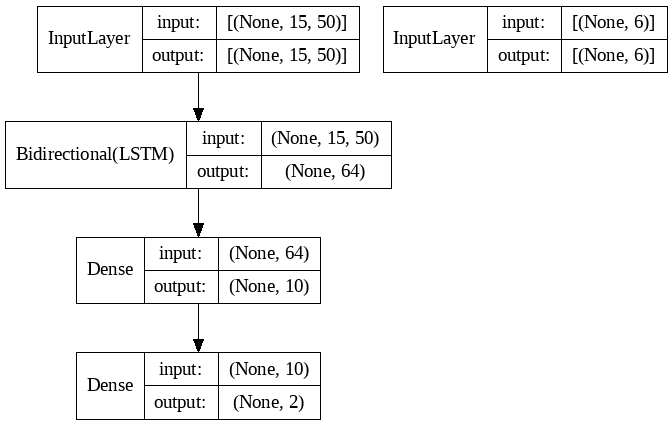

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Bidirectional, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import copy
tf.config.list_physical_devices('GPU')
tf.random.set_seed(42)


print('steps per epoch', steps_per_epoch)
print('validation steps', validation_steps)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Flatten, Concatenate, Dense

def define_model(input_shape_X_data, input_shape_X_ngram):
    # Input layers
    input_X_data = Input(shape=input_shape_X_data, name='X_data_input')
    input_X_ngram = Input(shape=input_shape_X_ngram, name='X_ngram_input')

    # BiLSTM layer
    lstm_units = 32
    lstm_layer = Bidirectional(LSTM(lstm_units, activation='relu'))

    # Apply BiLSTM to input_X_data
    lstm_output = lstm_layer(input_X_data)

    # Concatenate with input_X_ngram
    # concatenated = Concatenate()([lstm_output, input_X_ngram])

    # Dense layer
    dense_units = 10
    dense_output = Dense(units=dense_units, activation='relu')(lstm_output)

    # Output layer
    output = Dense(units=2, activation='softmax', name='output')(dense_output)

    # Define model
    model = Model(inputs=[input_X_data, input_X_ngram], outputs=output)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model


X_data, X_ngram, y_data = read_dataset("../generated/val/1260.txt")

input_shape_X_data = X_data.shape[1:]
input_shape_X_ngram = X_ngram.shape[1:]
model = define_model(input_shape_X_data, input_shape_X_ngram)  # define model

# plot model
image_name = '../images/model.png'
plot_model(model, image_name, show_shapes=True, show_layer_names=False)
display(Image(filename=image_name))

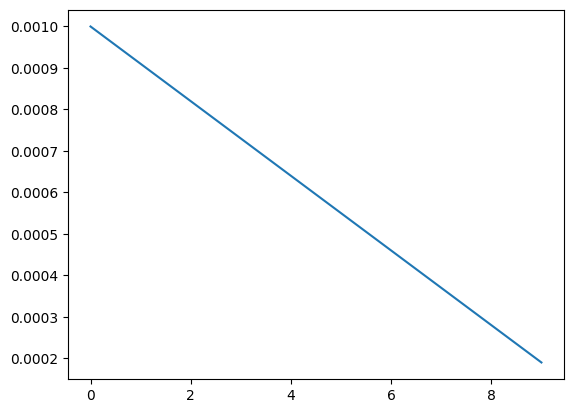

In [9]:
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from matplotlib import pyplot as plt

MODEL_ID = 'fixed-bilstm-nodict'

# checkpoint
filepath="../models/model-" +MODEL_ID+ "-{epoch:03d}-{accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

def step_decay(epoch):
    initial_lrate = 0.001
    min_lrat = 0.0001
    drop_per_epoch = (initial_lrate - min_lrat) / NB_EPOCH
    lrate = initial_lrate - (drop_per_epoch * epoch)
    return lrate

NB_EPOCH = 10
lrate = LearningRateScheduler(step_decay)

plt.plot([step_decay(i) for i in range(NB_EPOCH)]);
plt.savefig('../images/step-decay.png')

In [10]:
callbacks_list = [checkpoint, lrate]

history = model.fit(training_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=NB_EPOCH,
                    verbose=1,
                    callbacks=callbacks_list)

# save history as csv
import pandas as pd
df = pd.DataFrame(history.history)
df.to_csv(f'../models/{MODEL_ID}.csv', index=False)


Epoch 1/10


2024-06-22 10:18:02.905645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-22 10:18:04.435748: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2f141fe580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-22 10:18:04.435786: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-06-22 10:18:04.439623: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-22 10:18:04.448787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-06-22 10:18:04.

5131/5131 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8534

2024-06-22 10:24:57.874868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: accuracy improved from -inf to 0.85337, saving model to ../models/model-fixed-bilstm-nodict-001-0.8534.keras
5131/5131 [==============================] - 422s 82ms/step - loss: 0.3578 - accuracy: 0.8534 - val_loss: 0.2455 - val_accuracy: 0.8994 - lr: 0.0010
Epoch 2/10
5131/5131 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9298
Epoch 2: accuracy improved from 0.85337 to 0.92978, saving model to ../models/model-fixed-bilstm-nodict-002-0.9298.keras
5131/5131 [==============================] - 422s 82ms/step - loss: 0.1655 - accuracy: 0.9298 - val_loss: 0.1602 - val_accuracy: 0.9324 - lr: 9.1000e-04
Epoch 3/10
5131/5131 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9454
Epoch 3: accuracy improved from 0.92978 to 0.94536, saving model to ../models/model-fixed-bilstm-nodict-003-0.9454.keras
5131/5131 [==============================] - 431s 84ms/step - loss: 0.1327 - accuracy: 0.9454 - val_loss: 0.1474 - val_accuracy: 0.9434 - lr:

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# load model
from tensorflow.keras.models import load_model
from glob import glob

best_model_checkpoint = sorted(glob(f'../models/model-{MODEL_ID}*'))[-1]
print(best_model_checkpoint)

best_model = load_model(best_model_checkpoint)  # load Model

../models/model-fixed-bilstm-nodict-010-0.9696.keras


In [12]:
def predict(model, X_data, X_ngram):
    preds = model.predict([X_data, X_ngram])
    class_ = [np.argmax(pred) for pred in preds]
    print(class_)
    return class_

avg = {
    'precision': [],
    'recall': [],
    'fscore': [],
    'acc': []
}

for i, fpath in enumerate(file_test):
    print(f'{i+1}/{len(file_test)}: ', fpath)

    X_data, X_ngram, y_true = read_dataset(fpath)
    y_true = [np.argmax(y) for y in y_true]
    y_pred = predict(best_model, X_data, X_ngram)
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    acc = accuracy_score(y_true, y_pred)
    
    avg['precision'].append(precision)
    avg['recall'].append(recall)
    avg['fscore'].append(fscore)
    avg['acc'].append(acc)
    
    print('accuracy: ' , round(acc, 3))
    print('precision: ', round(precision, 3))
    print('recall: ', round(recall, 3))
    print('fscore: ', round(fscore, 3))
    print('Number of data: ', len(y_pred))
    print('-' * 50)

print('Average')
print('accuracy: ' , round(np.mean(avg['acc']) * 100, 3))
print('precision: ', round(np.mean(avg['precision']) * 100, 3))
print('recall: ', round(np.mean(avg['recall']) * 100, 3))
print('fscore: ', round(np.mean(avg['fscore']) * 100, 3))

1/2:  ../generated/test/1534.txt
4203/4203 [==============================] - 36s 9ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,